# Analisis de señales inerciales para la detección de fatiga en movimientos repetitivos

## Librerias utilizadas

In [1]:
import os
import sys
import pandas as pd
import tsfel
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Cargar datos

In [2]:
lpmsb2_dfs = {}
baseline_lpmsb2_dfs = {}
mpu6050_dfs = {}
baseline_mpu6050_dfs = {}

list_dir = os.listdir("./Datos/LPMS-B2")
for file in list_dir:
    if file.endswith("_calibracion.csv"):
        baseline_lpmsb2_dfs[file[:-16]]= pd.read_csv("./Datos/LPMS-B2/" + file)
    else:
        lpmsb2_dfs[file[:-4]]= pd.read_csv("./Datos/LPMS-B2/" + file)

list_dir = os.listdir("./Datos/MPU6050/")
columnas = ["timestamp", "AccX", "AccY" , "AccZ", "GyroX", "GyroY", "GyroZ"]
for file in list_dir:
    if file.endswith("_calibracion.csv"):
        baseline_mpu6050_dfs[file[:-16]]= pd.read_csv("./Datos/MPU6050/" + file, names=columnas)
    else:
        mpu6050_dfs[file[:-4]]= pd.read_csv("./Datos/MPU6050/" + file, names=columnas)

## Analisis exploratorio

### Analisis en el dominio del tiempo

#### MPU6050

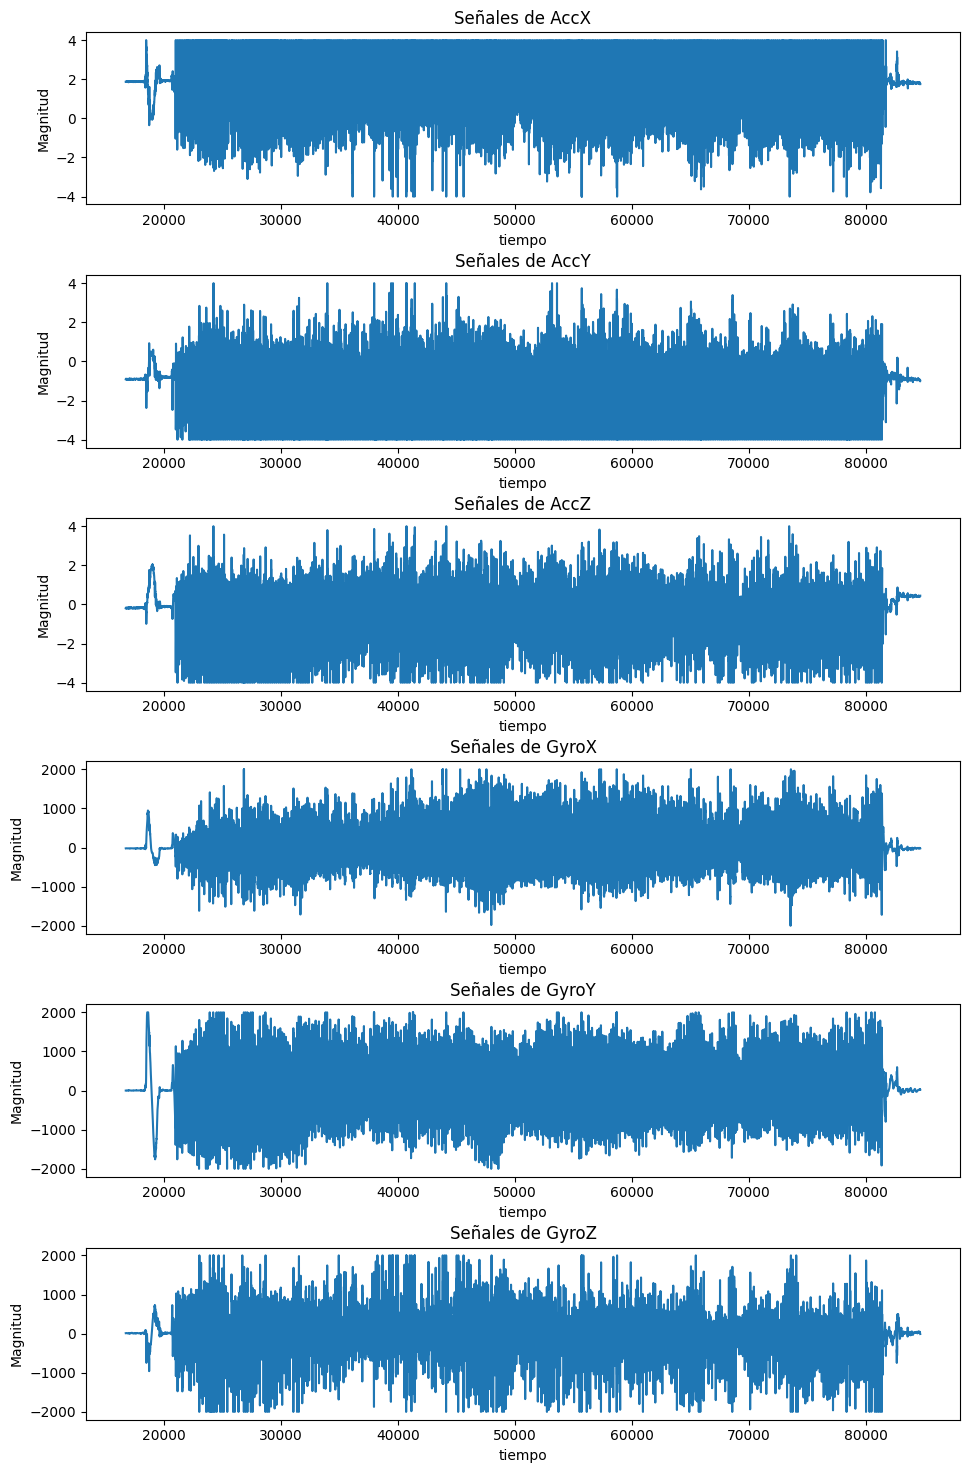

In [22]:
columns = ["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ"]

# Crear una figura y un conjunto de subgráficos
fig, axs = plt.subplots(len(columns), 1, figsize=(10, 15))

# Ajusta el espacio entre los gráficos para evitar que los títulos se superpongan
fig.tight_layout(pad=3.0)

# Generar un histograma para cada columna
for i, column in enumerate(columns):
    axs[i].plot(mpu6050_dfs["andres"]["timestamp"], mpu6050_dfs["andres"][column], label=column)
    axs[i].set_title(f'Señales de {column}')
    axs[i].set_xlabel("tiempo")
    axs[i].set_ylabel('Magnitud')

# Mostrar los histogramas
plt.show()


#### LPMS-B2

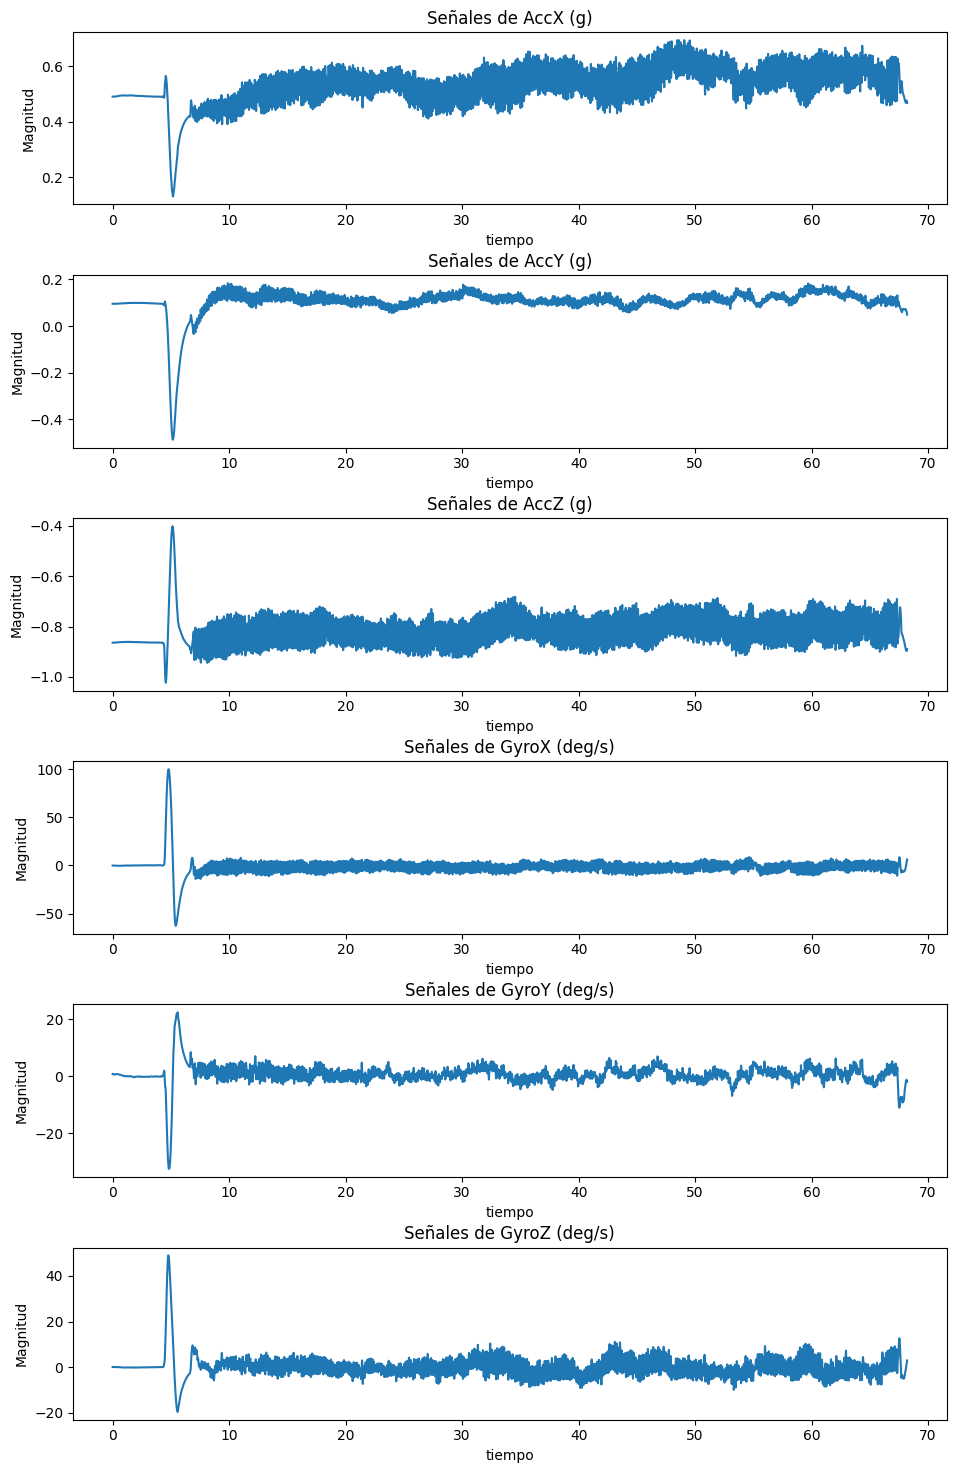

In [5]:
sujeto = "andres"
columns = lpmsb2_dfs[sujeto].columns[3:-17]

# Crear una figura y un conjunto de subgráficos
fig, axs = plt.subplots(len(columns), 1, figsize=(10, 15))

# Ajusta el espacio entre los gráficos para evitar que los títulos se superpongan
fig.tight_layout(pad=3.0)

# Generar un gráfico para cada columna
for i, column in enumerate(columns):
    axs[i].plot(lpmsb2_dfs[sujeto][' TimeStamp (s)'], lpmsb2_dfs[sujeto][column], label=column.strip())
    axs[i].set_title(f'Señales de {column.strip()}')
    axs[i].set_xlabel("tiempo")
    axs[i].set_ylabel('Magnitud')
plt.show()


### Analisis en el dominio de frecuencias

#### LPMS-B2

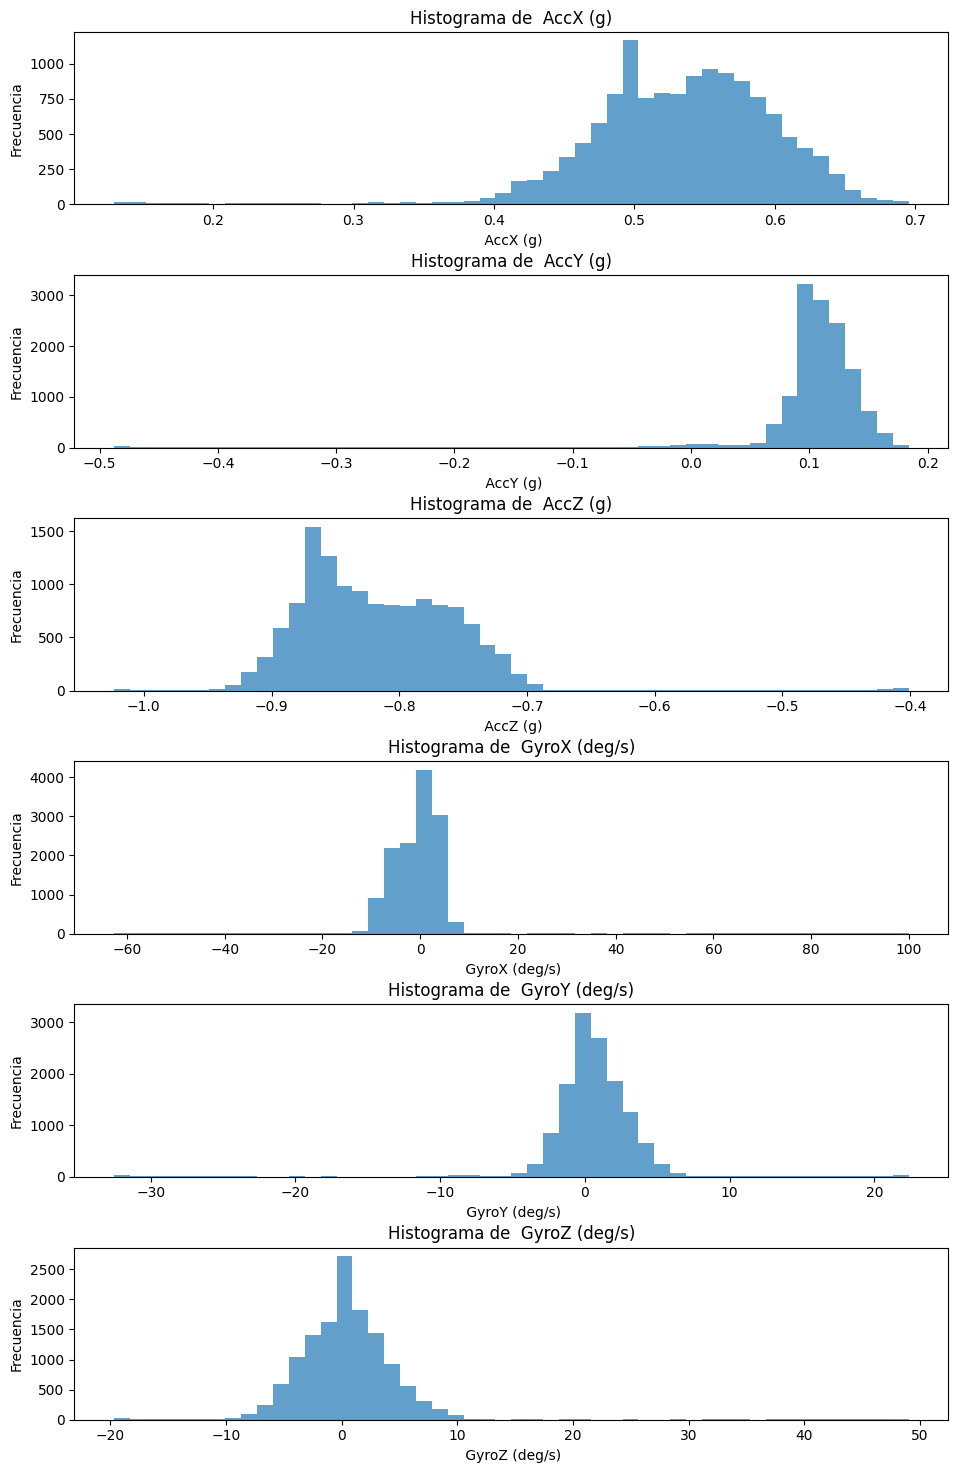

In [7]:
# Asumiendo que 'df' es tu DataFrame
# df = pd.read_csv('tu_archivo.csv')  # Descomenta y ajusta esto si necesitas cargar el DataFrame desde un archivo

# Lista de las columnas para las que quieres hacer histogramas
sujeto = "andres"
columns = lpmsb2_dfs[sujeto].columns[3:-17]

# Crear una figura y un conjunto de subgráficos
fig, axs = plt.subplots(len(columns), 1, figsize=(10, 15))

# Ajusta el espacio entre los gráficos para evitar que los títulos se superpongan
fig.tight_layout(pad=3.0)

# Generar un histograma para cada columna
for i, column in enumerate(columns):
    axs[i].hist(lpmsb2_dfs["andres"][column], bins=50, alpha=0.7)
    axs[i].set_title(f'Histograma de {column}')
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frecuencia')

# Mostrar los histogramas
plt.show()


#### MPU6050

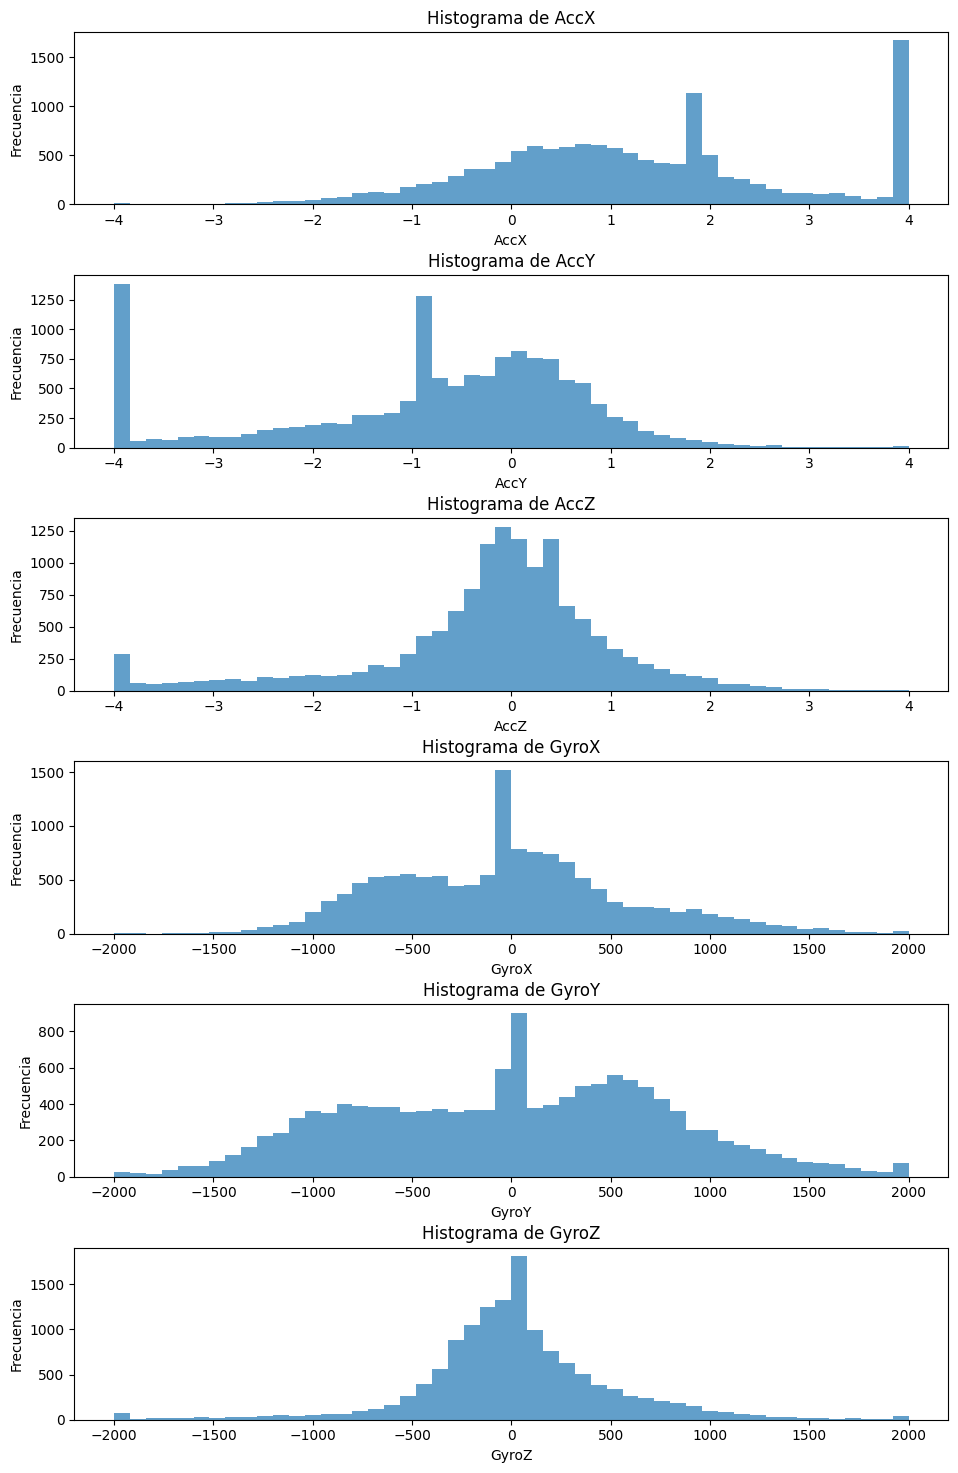

In [8]:
columns = ["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ"]

# Crear una figura y un conjunto de subgráficos
fig, axs = plt.subplots(len(columns), 1, figsize=(10, 15))

# Ajusta el espacio entre los gráficos para evitar que los títulos se superpongan
fig.tight_layout(pad=3.0)

# Generar un histograma para cada columna
for i, column in enumerate(columns):
    axs[i].hist(mpu6050_dfs["andres"][column], bins=50, alpha=0.7)
    axs[i].set_title(f'Histograma de {column}')
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frecuencia')

# Mostrar los histogramas
plt.show()


## Limpieza y Preprocesado de datos

## Aproach Personalizado

### Extracción de caracteristicas

### Selección de atributos

## Aproach Generalizado

### Extracción de caracteristicas

### Selección de atributos

## Validación Cruzada

## Entrenamiento

## Validación